Задание №26

ДЗ должна быть выполнена строго на torch <br>
1 - использовать dataloader. <br>
2 - в цикл обучения добавить сохранения лучшей модели / шедулер для скорости обучения. <br>
3 - вывести графики обучения. Выводить информацию по обучению в процессе. <br>

Решить задачу предсказания возраста. Свести к задаче классификации. 
0-9, 10-19, 20-29, 30-39, 40-49, 50-59, ...
 
В качестве фичеэкстрактора используйте любую вариацию vit. ** -

Анализ и план работы: <br>
Загружаем данные из предварительно очищенного и обработанного датасета wiki_crop (полученного при выполнении предыдущей работы). <br>
При загрузке файлов извлекаем возраст из заголовка файла и назначаем файлу метку от 0 до 9 в соответствии с разбиением отрезка 0-100 на десятилетия. <br>
Загружаем предобученную сеть VIT. Изменяем последний слой для выдачи решения задачи классификации. <br>
Обучаем сеть, контролируя качество обучения с помощью валидационной выборки, функция качества log loss для определения возраста. <br>
Строим графики. <br>
Проверяем метрики на тестовом наборе. <br>
Делаем выводы.

1. Loading necessary modules:

In [6]:
%reset -f 

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torchvision.models import vit_b_16

import requests
from transformers import AutoModelForImageClassification, AutoImageProcessor
from PIL import Image

import os, re, cv2
from datetime import datetime

2. CUDA enable (pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118)

In [7]:
print(f'CUDA is available: {torch.cuda.is_available()}')       # True
if torch.cuda.is_available():
    print(f'Device count: {torch.cuda.device_count()}')        # 1
    print(f'Current device #: {torch.cuda.current_device()}')  # 0
    print(f'GPU name: {torch.cuda.get_device_name(0)}') 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
# device = 'cpu'
# print(f'Now Device: {device}')

CUDA is available: False
Device: cpu


3. Custom dataset

In [8]:
# Custom Dataset for loading images, and age label calculation
class AgeDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.image_paths = []
        self.age_classes = []

        # Loading images, calculating the age
        for file_name in os.listdir(folder):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Extracting date of birth and the year of photo taking
                match = re.search(r'_(\d{4})-(\d{2})-(\d{2})_(\d{4})', file_name)
                if match:
                    birth_year = int(match.group(1))
                    birth_month = int(match.group(2))
                    birth_day = int(match.group(3))
                    if birth_day == 0: # sometimes in the dataset we have zeroth date of birth
                        birth_day = 1
                    shoot_year = int(match.group(4))
                    # print(f'Y: {birth_year}, M: {birth_month}, D: {birth_day}, Shoot: {shoot_year}')
                    # Age calculation:
                    birth_date = datetime(birth_year, birth_month, birth_day)
                    shoot_date = datetime(shoot_year, 7, 1)  # Say the photo is taken on the 1st of July (middle of the year)
                    age = (shoot_date - birth_date).days // 365  # Age in years
                    if age >= 0: # there is possibility for age to be less than zero, it's an error
                        # calculating class label:
                        age_label = age // 10
                        if age_label > 9:
                            age_label = 9 
                        self.image_paths.append(os.path.join(folder, file_name))
                        self.age_classes.append(age_label)
        # print(self.age_classes)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        age_label = self.age_classes[idx]
        # print(age_class)
        image_bgr = cv2.imread(image_path)  # Load image 
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) # convert to RGB

        if self.transform:
            image_rgb = self.transform(image_rgb)  # Transform to pytorch tensor; also normalize

        # return image_rgb, torch.tensor(age_label, dtype=torch.int64)
        return image_rgb, age_label

4. Loading the data (pre-processed images) and calculating corresponding ages of people and the labels for the age

In [9]:
# Folder with the images prepared
folder ='wiki_crop_cleaned'
 
# Transforms for the images
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalizing images
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization like in ImageNet
                         
])

# Creating the Dataset
dataset = AgeDataset(folder, transform=transform)

# Splitting the Dataset into traning, validation and the test one
train_size = int(0.7 * len(dataset))  # 70% for the train
val_size = int(0.15 * len(dataset))   # 15% for the validation
test_size = len(dataset) - train_size - val_size  # the rest 15% for the test 

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# saving datasets for reproducible stop and rerun of the neural network training

# Save indices to corresponding variables
train_indices = train_dataset.indices
val_indices = val_dataset.indices
test_indices = test_dataset.indices

4. Initializing the VIT model (and loading the previosly saved state if any)

In [10]:
num_classes = 10 # ten classes for ages from 0 to 99

# Load pretrained ViT model
# model = vit_b_16(pretrained=True)

model = AutoModelForImageClassification.from_pretrained("OpenGVLab/pvt_v2_b0")
processor = AutoImageProcessor.from_pretrained("OpenGVLab/pvt_v2_b0")

c:\Users\varaksa_yua\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\varaksa_yua\.cache\huggingface\hub\models--OpenGVLab--pvt_v2_b0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


NameError: name 'init_empty_weights' is not defined

In [ ]:
# Freeze all parameters
for name, param in model.named_parameters():
    if "classifier" not in name:  # Или любое другое условие для выбора слоев
        param.requires_grad = False    

# new classifier layer
model.classifier= nn.Sequential(
          nn.Linear(256, num_classes))

In [ ]:
# Optimizer and loss function 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  #

# Decreasing learning rate scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=1, factor=0.5, verbose=True)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=0)  # T_max: Number of epochs for decay

# Trying to read the saved checkpoint to restore models state for keeping on the training
try:
    checkpoint = torch.load('checkpoint_vit_v2.pth')
    model.load_state_dict(checkpoint['model_state_dict']) # load model state       
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # Move optimizer to the device being used
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
    train_loss_values = checkpoint['train_loss_values']
    val_accuracy_values = checkpoint['val_accuracy_values']
    current_epoch = checkpoint['epoch'] 
    # to remember the datasets for restarting training process
    train_indices = checkpoint['train_indices']
    val_indices = checkpoint['val_indices']
    test_indices = checkpoint['test_indices']
    print('Checkpoint loaded')
except:
    current_epoch = 1        
    train_loss_values = []
    val_accuracy_values = []
    print('No checkpoint loaded')
    
# Trying to read the saved best model checkpoint to extract the best validation accuracy reached
try:
    checkpoint_best = torch.load('best_model_vit_v2.pth')
    best_val_accuracy =  checkpoint_best['best_val_accuracy']  
    print('Best model loaded')
except:
    best_val_accuracy = 0     
    print('No best model loaded')

# Move the model to GPU if available, otherwise to CPU
model = model.to(device)

C:\Users\User\AppData\Local\Temp\ipykernel_15308\1442437008.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint_vit_v2.pth')
C:\Users\Us

Checkpoint loaded
Best model loaded


4a. Recreate Datasets and DataLoaders in accordance with the indices loaded from the saved checkpoint, if any

In [ ]:
# This is done for the dataloaders to be identical at each file run
# (additionally, this changes nothing if no checkpoint is loaded, 
# otherwise it restores datasets and dataloader used at previously stage of training)

batch_size = 32

# Recreate subsets using Subset
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Create DataLoaders (or create them from datasets just loaded)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

5. Model training

In [ ]:
epochs = 15

while current_epoch <= epochs:
    print(f'Epoch [{current_epoch}/{epochs}]')
    model.train()
    running_loss = 0.0
    i = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # print(f'Current batch: {i}')
        i += 1
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        tmp = outputs.to_tuple()[0] # extract output tensor
        loss = criterion(tmp, labels) #
        # print(f'Loss for the current batch: {loss:.2f}')
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    average_loss = running_loss/len(train_loader) # len(train_loader) is the total number of batches
    print(f'Average Loss: {average_loss}')
    train_loss_values.append(average_loss) # appending new value of average loss
    
   
    model.eval()
    # evaluation on the validation dataset
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            tmp = outputs.to_tuple()[0] # extract output tensor
            _, predicted = torch.max(tmp, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()            
  
    val_accuracy = 100 * correct_val / total_val
    print(f'Current Validation Accuracy: {val_accuracy:.2f}%')
    val_accuracy_values.append(val_accuracy)
    
    # Keep the best model if validation accuracy improves
    if val_accuracy >= best_val_accuracy:
        print(f"Best Validation Accuracy reached so far: {best_val_accuracy:.2f} %")        
        best_val_accuracy = val_accuracy        
        torch.save({'model_state_dict': model.state_dict(),  # model weights
                    'best_val_accuracy' : best_val_accuracy}, 
                   'best_model_vit_v2.pth')
        print(f"New best model saved with new Validation Accuracy: {best_val_accuracy:.2f}%")   

    # Decreasing the learning rate
    # scheduler.step(best_val_accuracy) # for reduce on plateau
    scheduler.step() # for cosine annealing
    
    current_epoch += 1

Epoch [6/15]
Average Loss: 1.4403301699318154
Current Validation Accuracy: 39.18%
Best Validation Accuracy reached so far: 39.18 %
New best model saved with new Validation Accuracy: 39.18%
Epoch [7/15]
Average Loss: 1.4403097888414007
Current Validation Accuracy: 39.18%
Best Validation Accuracy reached so far: 39.18 %
New best model saved with new Validation Accuracy: 39.18%
Epoch [8/15]
Average Loss: 1.4402935306956297
Current Validation Accuracy: 39.18%
Best Validation Accuracy reached so far: 39.18 %
New best model saved with new Validation Accuracy: 39.18%
Epoch [9/15]
Average Loss: 1.4403201835433932
Current Validation Accuracy: 39.18%
Best Validation Accuracy reached so far: 39.18 %
New best model saved with new Validation Accuracy: 39.18%
Epoch [10/15]
Average Loss: 1.440313409497268
Current Validation Accuracy: 39.18%
Best Validation Accuracy reached so far: 39.18 %
New best model saved with new Validation Accuracy: 39.18%
Epoch [11/15]
Average Loss: 1.4402958277585733
Current 

6. Saving the current state of the model (so-called checkpoint)

In [ ]:
# Save model weights and additional information like optimizer state, epoch, etc.
try:
    torch.save({
        'epoch': current_epoch,
        'model_state_dict': model.state_dict(),  # model weights
        'optimizer_state_dict': optimizer.state_dict(), # optimizer   
        'train_loss_values' : train_loss_values,
        'val_accuracy_values' : val_accuracy_values,
        'train_indices': train_indices,
        'val_indices': val_indices,
        'test_indices': test_indices 
        }, 'checkpoint_vit_v2.pth')
except:
    print('Error. No current model saved')

7. Evaluation of the current model on the test dataset

In [ ]:
# evaluation of the current model on the test dataset
total_test = 0
correct_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        tmp = outputs.to_tuple()[0] # extract output tensor
        _, predicted = torch.max(tmp, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()            
  
test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy for the current model: {test_accuracy:.2f} %')

Test Accuracy for the current model: 33.73 %


8. Training plots 

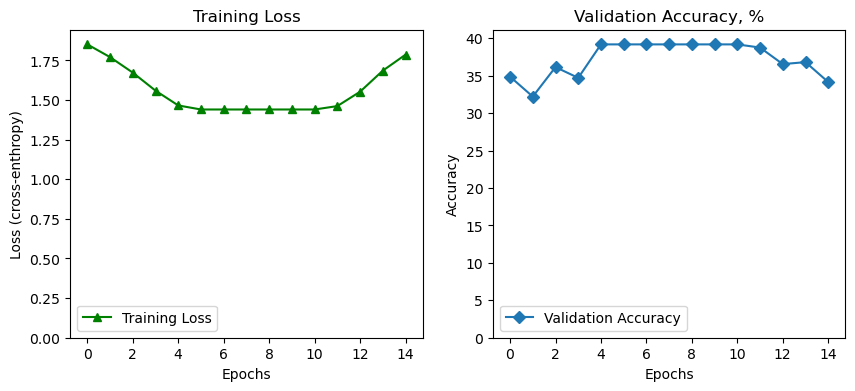

In [ ]:
import matplotlib.pyplot as plt

# Learning plots

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss_values, 'g-^', label='Training Loss') # 'g^-' - green triangles + solid line
plt.xlabel('Epochs')
plt.ylabel('Loss (cross-enthropy)')
plt.title('Training Loss')
plt.legend()
plt.axis([-0.05*epochs, 1.05*epochs-1, 0, 1.05*max(train_loss_values)])

plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_accuracy_values, 'D-', label = 'Validation Accuracy') # 'D-' diamonds + solid line
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy, %')
plt.legend()
plt.axis([-0.05*epochs, 1.05*epochs-1, 0, 1.05*max(val_accuracy_values)])

plt.show()

9. Loading the best model (i.e. showing the best metrics on the validation dataset)

In [ ]:
try:
    checkpoint_best = torch.load('best_model_vit_v2.pth', map_location=torch.device(device.type)) # loads model with mapping the storages to the CPU/GPU if any
    model.load_state_dict(checkpoint_best['model_state_dict']) # load model state
    tmp = checkpoint_best['best_val_accuracy']     
    print(f'Best validation accuracy reached: {tmp:.2f}')   
except:
    print('Error. No best model found')

Best validation accuracy reached: 39.18


C:\Users\User\AppData\Local\Temp\ipykernel_15308\1757296826.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_best = torch.load('best_model_vit_v2.pth', map_loc

10. Final evaluation of the best model on the test dataset 

In [ ]:
model.eval() # switch the loaded model to the evaluation mode 

# evaluation of the best model on the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        tmp = outputs.to_tuple()[0] # extract output tensor
        _, predicted = torch.max(tmp, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()            
  
test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy of the best model: {test_accuracy:.2f}%')

Test Accuracy of the best model: 35.77%


**Выводы:** <br>
На основе предобученной нейронной сети VIT произведено решение задачи классификации на предварительно обработанных снимках из датасета wiki_crop для определения диапазона возраста персонажа на снимках <br>

Достигнутая точность решения задачи классификации (а именно, точность попадания найденного нейросетью возраста в правильный десятилетний диапазон возрастов ) на тестовой выборке составила: <br> 

на короткой выборке из 500 рисунков <br>
28% (20 эпох) <br>

на полной выборке из 25000 рисунков <br>
37.80% (5 эпох) <br>
35.77% (15 эпох) <br>
% (15 эпох) <br>
% (20 эпох) <br>
